Import Relevant Libraries

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import stax
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from jax.lib import xla_bridge
from google.colab import drive, files

Get Training and Test Data

In [ ]:
drive.mount('/content/drive')

# Get training dataset:
with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_700mV/x_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

L = (0.3/2210)

raw = np.array(df['19'])*L
t_train = np.arange(len(raw), dtype=np.float32) 
x_train_mean = raw.mean(axis=0)
# x_train_std = 1
x_train_std = raw.std(axis=0)
x_train = (raw - x_train_mean) / x_train_std 
xdot_train = np.gradient(x_train, t_train)
xdotdot_train = np.gradient(xdot_train, t_train)

with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_700mV/y_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])*L
y_train_mean = raw.mean(axis=0)
# y_train_std = 1
y_train_std = raw.std(axis=0)
y_train = (raw - y_train_mean) / y_train_std 
ydot_train = np.gradient(y_train, t_train)
ydotdot_train = np.gradient(ydot_train, t_train)

x_train = np.stack((x_train, y_train, xdot_train, ydot_train), axis=1)
xt_train = np.stack((xdot_train, ydot_train, xdotdot_train, ydotdot_train), axis=1)

# Get testing dataset:
with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_600mV/x_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])*L
t_test = np.arange(len(raw), dtype=np.float32) 
x_test_mean = raw.mean(axis=0)
# x_test_std = 1
x_test_std = raw.std(axis=0)
x_test = (raw - x_test_mean) / x_test_std 
xdot_test = np.gradient(x_test, t_test)
xdotdot_test = np.gradient(xdot_test, t_test)

with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_600mV/y_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])*L
y_test_mean = raw.mean(axis=0)
# y_test_std = 1
y_test_std = raw.std(axis=0)
y_test = (raw - y_test_mean) / y_test_std 
ydot_test = np.gradient(y_test, t_test)
ydotdot_test = np.gradient(ydot_test, t_test)

x_test = np.stack((x_test, y_test, xdot_test, ydot_test), axis=1)
xt_test = np.stack((xdot_test, ydot_test, xdotdot_test, ydotdot_test), axis=1)

Mounted at /content/drive


Define Relevant Functions

In [ ]:
# LNN Model
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

# Use the odeint to solve the Lagrangian modelled system.
def solve_lagrangian(lagrangian, initial_state, **kwargs):
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

# Ensure that all inputs are normalised to only vary between -1 and 1. 
def normalise(state):
  return jnp.concatenate([state[:2], state[2:]])
# def normalise(state):
#   return jnp.concatenate([(state[:2] + 1) % (2) - 1, state[2:]])

# Define 4th order Runge-Kutta method for integration of losses. 
def rk4_step(f, x, t, h):
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

Initialise Neural Network

In [ ]:
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalise(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# Now we define the loss function of the model. In our case it is the Mean 
# Squared Error between the predicted and the observed accelerations. 
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# Set up the Neural Network. 
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

Train the Neural Network

In [ ]:
# Initialise the parametes in the neural network to be random. 
%%time 
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# Define the training process. 
batch_size = 100
test_every = 10
num_batches = 500 # Further training seems to overfit the model. 

train_losses = []
test_losses = []

# Define the training optimiser.
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

# Perform training process. 
for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))*1000
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))*1000
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=15986.665039, test_loss=16006.288086
iteration=1000, train_loss=0.224824, test_loss=0.160098
iteration=2000, train_loss=0.218775, test_loss=0.156413
iteration=3000, train_loss=0.210841, test_loss=0.150073
iteration=4000, train_loss=0.200872, test_loss=0.143260
iteration=5000, train_loss=0.189278, test_loss=0.137402
iteration=6000, train_loss=0.177841, test_loss=0.134073
iteration=7000, train_loss=0.167461, test_loss=0.132705
iteration=8000, train_loss=0.163159, test_loss=0.132977
iteration=9000, train_loss=4.199502, test_loss=4.092244
iteration=10000, train_loss=0.326551, test_loss=0.308035
iteration=11000, train_loss=0.148888, test_loss=0.136832
iteration=12000, train_loss=0.148945, test_loss=0.136390
iteration=13000, train_loss=0.147579, test_loss=0.136691
iteration=14000, train_loss=0.142529, test_loss=0.141898
iteration=15000, train_loss=0.142841, test_loss=0.140053
iteration=16000, train_loss=0.139020, test_loss=0.146795
iteration=17000, train_loss=0.137457

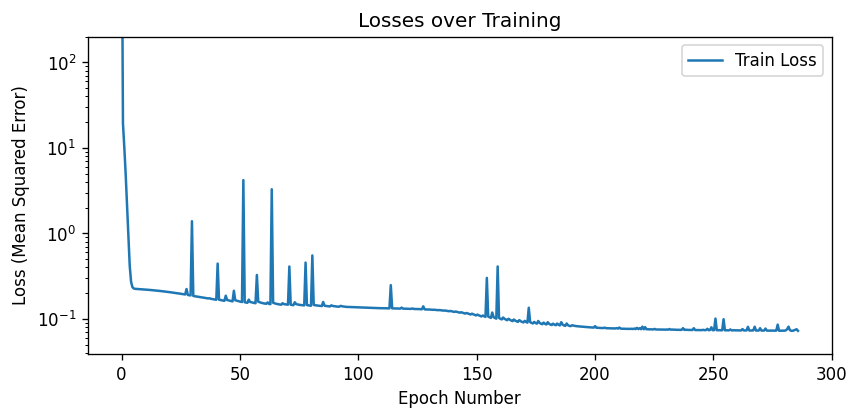

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
epochs = np.linspace(0, ((batch_size/(175))*num_batches), (num_batches + 1))
plt.plot(epochs, train_losses, label='Train Loss')
# plt.plot(epochs, test_losses, label='Test Loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over Training')
plt.xlabel("Epoch Number")
plt.ylabel("Loss (Mean Squared Error)")
plt.legend()
plt.show()

Make Predictions Using Trained Model

In [ ]:
# Compare to training dataset.
experimental = x_train
N = len(x_train[:, 0])
time = np.linspace(0, N, N)
X0 = x_train[0, :]
predicted = solve_lagrangian(learned_lagrangian(params), X0, t=time) # jax.device_get(solve_lagrangian(learned_lagrangian(params), X0, t=time))
# predicted = solve_lagrangian(learned_lagrangian(params), X0, t=time)
time = time*0.003

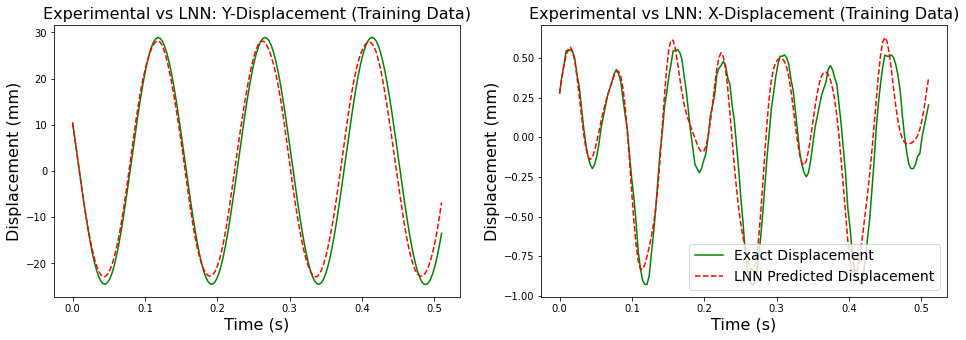

Absolute Performance:
RMS Error in Y:  0.002921756
RMS Error in X:  0.00013172739
Normalised Performance:
RMS Error in Y:  0.1524789
RMS Error in X:  0.30781257


In [ ]:
# De-normalise the data and scale it to real-life. 
experimental[:, 0] = (experimental[:, 0] * x_train_std) #+ x_train_mean
experimental[:, 1] = (experimental[:, 1] * y_train_std) #+ y_train_mean
model = np.empty_like(predicted)
model_x = (predicted[:, 0] * x_train_std) #+ x_train_mean
model_y = (predicted[:, 1] * y_train_std) #+ y_train_mean

figure, axis = plt.subplots(1, 2, figsize=(16,5))
plt.rc('xtick', labelsize= 16)
plt.rc('ytick', labelsize= 16)

axis[0].set_title("Experimental vs LNN: Y-Displacement (Training Data)", fontsize=16)
axis[0].plot(time, experimental[:, 1]*1000, 'g-', label=r'Exact Displacement')
axis[0].plot(time, model_y*1000, 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (mm)", fontsize=16)

axis[1].set_title("Experimental vs LNN: X-Displacement (Training Data)", fontsize=16)
axis[1].plot(time, experimental[:, 0]*1000, 'g-', label=r'Exact Displacement')
axis[1].plot(time, model_x*1000, 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (mm)", fontsize=16)
axis[1].legend(fontsize=14, loc='lower right')

plt.show()

print('Absolute Performance:')

E2_error = 0
for i in range(0, len(time)):
  E2_error = E2_error + (abs((experimental[i, 1] - model_y[i])**2))
E2_error = (E2_error / len(model_y))**0.5
print("RMS Error in Y: ", E2_error)

E2_error = 0
for i in range(0, len(time)):
  E2_error = E2_error + (abs((experimental[i, 0] - model_x[i])**2))
E2_error = (E2_error / len(model_x))**0.5
print("RMS Error in X: ", E2_error)

print('Normalised Performance:')
# Normalise the results so that their errors can be compared. 
experimental[:, 0] = experimental[:, 0]/np.std(experimental[:, 0])
experimental[:, 1] = experimental[:, 1]/np.std(experimental[:, 1])
model_x = model_x/np.std(model_x)
model_y = model_y/np.std(model_y)

E2_error = 0
for i in range(0, len(time)):
  E2_error = E2_error + (abs((experimental[i, 1] - model_y[i])**2))
E2_error = (E2_error / len(model_y))**0.5
print("RMS Error in Y: ", E2_error)

E2_error = 0
for i in range(0, len(time)):
  E2_error = E2_error + (abs((experimental[i, 0] - model_x[i])**2))
E2_error = (E2_error / len(model_x))**0.5
print("RMS Error in X: ", E2_error)

In [ ]:
# # Compare to testing dataset. 
# experimental = x_test
# N = len(x_test[:, 0])
# time = np.linspace(0, N, N)
# X0 = x_test[0, :]
# predicted = jax.device_get(solve_lagrangian(learned_lagrangian(params), X0, t=time))
# time = time*0.003

# # De-normalise the data and scale it to real-life. 
# experimental[:, 0] = (experimental[:, 0] * x_test_std) #+ x_train_mean
# experimental[:, 1] = (experimental[:, 1] * y_test_std) #+ y_train_mean
# model = np.empty_like(predicted)
# model_x = (predicted[:, 0] * x_test_std) #+ x_train_mean
# model_y = (predicted[:, 1] * y_test_std) #+ y_train_mean


# # Plot them alongside. 
# figure, axis = plt.subplots(2, 1, figsize=(10,15))

# axis[0].set_title("Experimental vs LNN: Y-Displacement (Testing Data)", fontsize=16)
# axis[0].plot(time, experimental[:, 1]*1000, 'g-', label=r'Exact Displacement')
# axis[0].plot(time, model_y*1000, 'r--', label=r'LNN Predicted Displacement')
# axis[0].set_xlabel("Time (s)", fontsize=16)
# axis[0].set_ylabel("Displacement (mm)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')

# axis[1].set_title("Experimental vs LNN: X-Displacement (Testing Data)", fontsize=16)
# axis[1].plot(time, experimental[:, 0]*1000, 'g-', label=r'Exact Displacement')
# axis[1].plot(time, model_x*1000, 'r--', label=r'LNN Predicted Displacement')
# axis[1].set_xlabel("Time (s)", fontsize=16)
# axis[1].set_ylabel("Displacement (mm)", fontsize=16)
# axis[1].legend(fontsize=14, loc='lower right')

# plt.rc('xtick', labelsize=16) 
# plt.rc('ytick', labelsize=16) 
# plt.rc('axes', labelsize=14) 

# print('RMS Performance:')
# # Normalise the results so that their errors can be compared. 

# E2_error = 0
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((experimental[i, 1] - model_y[i])**2))
# E2_error = (E2_error / len(model_y))**0.5
# print("RMS Error in Y: ", E2_error)

# E2_error = 0
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((experimental[i, 0] - model_x[i])**2))
# E2_error = (E2_error / len(model_x))**0.5
# print("RMS Error in X: ", E2_error)

# print('Normalised RMS Performance:')
# # Normalise the results so that their errors can be compared. 
# experimental[:, 0] = experimental[:, 0]/np.std(experimental[:, 0])
# experimental[:, 1] = experimental[:, 1]/np.std(experimental[:, 1])
# model_x = model_x/np.std(model_x)
# model_y = model_y/np.std(model_y)

# E2_error = 0
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((experimental[i, 1] - model_y[i])**2))
# E2_error = (E2_error / len(model_y))**0.5
# print("RMS Error in Y: ", E2_error)

# E2_error = 0
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((experimental[i, 0] - model_x[i])**2))
# E2_error = (E2_error / len(model_x))**0.5
# print("RMS Error in X: ", E2_error)

In [ ]:
# # Make predictions with testing dataset beyond the experimentally observed time period. 
# experimental = x_test
# N = len(x_test[:, 0])
# time = np.linspace(0, 4*N, 2*N)
# X0 = x_test[0, :]
# predicted = solve_lagrangian(learned_lagrangian(params), X0, t=time)
# time = time*0.003

# # De-normalise the data and scale it to real-life. 
# experimental[:, 0] = (experimental[:, 0] * x_test_std) 
# experimental[:, 1] = (experimental[:, 1] * y_test_std) 
# model = np.empty_like(predicted)
# model[:, 0] = (predicted[:, 0] * x_test_std) 
# model[:, 1] = (predicted[:, 1] * y_test_std) 

# # Plot them alongside. 
# figure, axis = plt.subplots(2, 1, figsize=(25,15))

# axis[0].set_title("Experimental vs LNN: Y-Displacement (Testing Data Extended)", fontsize=16)
# axis[0].plot(time[0:N], experimental[:, 1], 'g-', label=r'Exact Displacement')
# axis[0].plot(time, model[:, 1], 'r--', label=r'LNN Predicted Displacement')
# axis[0].set_xlabel("Time (s)", fontsize=16)
# axis[0].set_ylabel("Displacement (mm)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# axis[1].set_title("Experimental vs LNN: X-Displacement (Testing Data Extended)", fontsize=16)
# axis[1].plot(time[0:N], experimental[:, 0], 'g-', label=r'Exact Displacement')
# axis[1].plot(time, model[:, 0], 'r--', label=r'LNN Predicted Displacement')
# axis[1].set_xlabel("Time (s)", fontsize=16)
# axis[1].set_ylabel("Displacement (mm)", fontsize=16)
# axis[1].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')